In [1]:
import sys

sys.path.insert(1, "/home/vinicius/Documentos/StuartLandauWBM/")

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

from src.models import simulate, simulate2, simulate_delayed

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [71]:
jax.config.update("jax_platform_name", "cpu")

# x = jax.numpy.square(2)
# print(repr(x.device_buffer.device()))
#
## Load anatomical data
data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()

# Graph parameters
Nareas = 29  # Number of areas
# FLN matrix
flnMat = data["FLN"]
# Distance matrix
D = data["Distances"] * 1e-3 / 3.5
# Hierarchy values
h = np.squeeze(data["Hierarchy"].T)

eta = 4.0

## Simulation parameters

ntrials = 30
fsamp = 1 / 1e-4
time = np.arange(-2, 5, 1 / fsamp)
beta = 0.001
Npoints = len(time)
# Convert to timesteps
# D = (D * fsamp).astype(int)

f = 40  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz

g = 1
flnMat = (1 + eta * h)[:, np.newaxis] * flnMat

In [94]:
out = simulate2(
    flnMat,
    g,
    40,
    np.linspace(-5, 1, Nareas),
    1 / 1e-4,
    beta,
    5 / 1e-4,
    0,
    0,
    10,
    "cpu",
    1,
)

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [95]:
z = (out - out.mean(1, keepdims=True)) / out.std(1, keepdims=True)

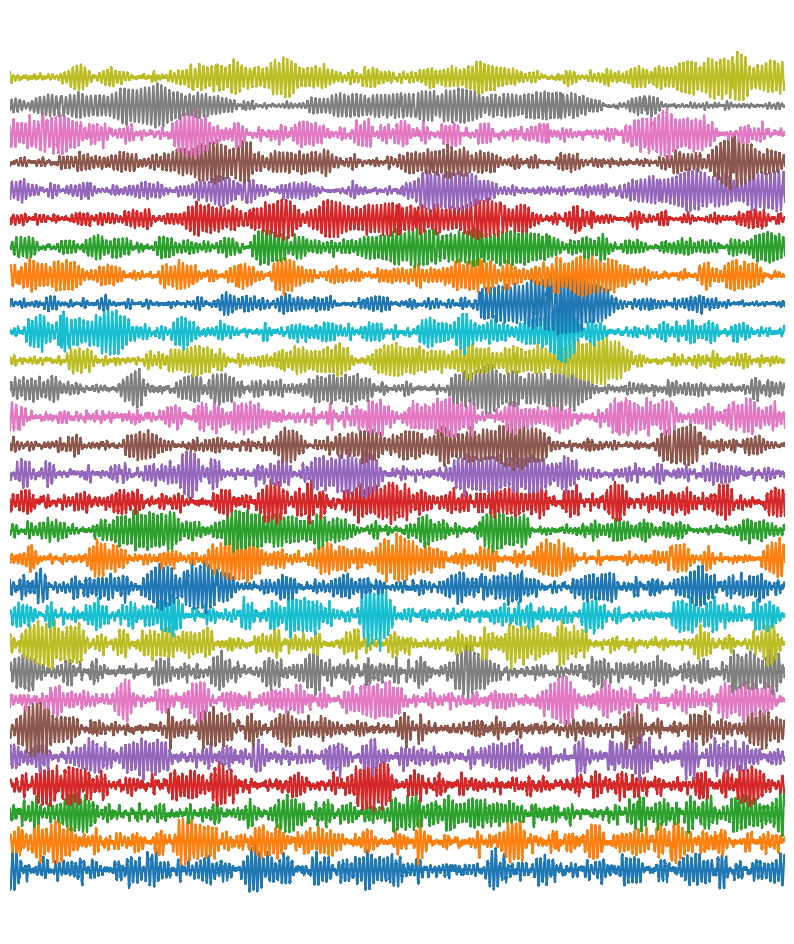

In [96]:
plt.figure(figsize=(10, 12))
for i in range(Nareas):
    plt.plot(z[i].real + (i * 3))
plt.xlim(2500, 5 / 1e-4)
plt.axis("off");

In [98]:
out = []
for i in range(ntrials):
    out += [
        simulate2(
            flnMat,
            0.1 + (0.3 * i),
            40,
            np.linspace(-5, 1, Nareas),
            1 / 1e-4,
            beta,
            5 / 1e-4,
            0,
            0,
            i,
            "cpu",
            10,
        )
    ]

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/vinicius/anaconda3/

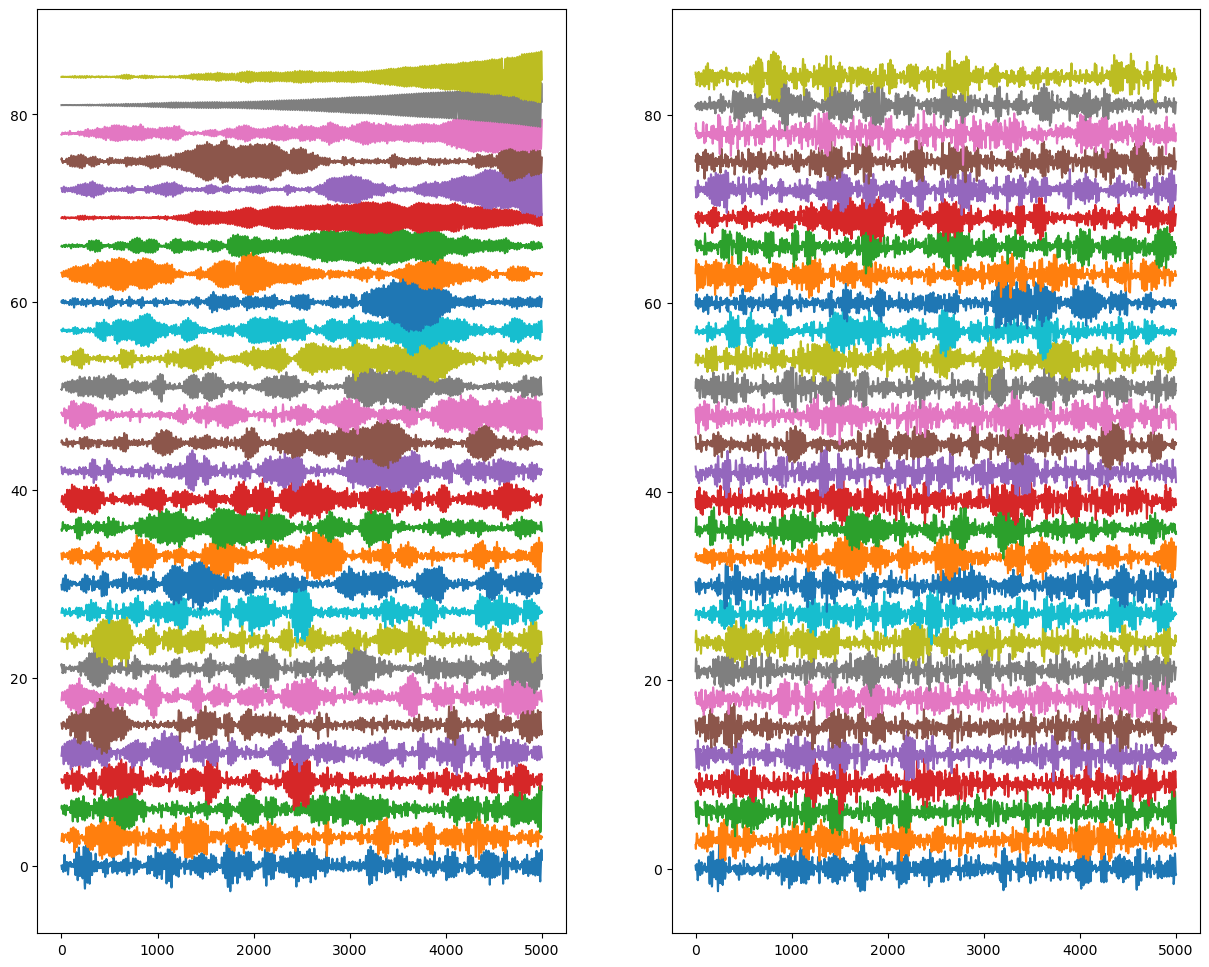

In [100]:
plt.figure(figsize=(15, 12))

data = np.stack(out)
data.shape

### Convert to xarray

area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "8m",
    "5",
    "8l",
    "TEO",
    "2",
    "F1",
    "STPc",
    "7A",
    "46d",
    "10",
    "9/46v",
    "9/46d",
    "F5",
    "TEpd",
    "PBr",
    "7m",
    "7B",
    "F2",
    "STPi",
    "PROm",
    "F7",
    "8B",
    "STPr",
    "24c",
]

data = xr.DataArray(data, dims=("trials", "roi", "times"), coords={"roi": area_names})

## Plot

z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

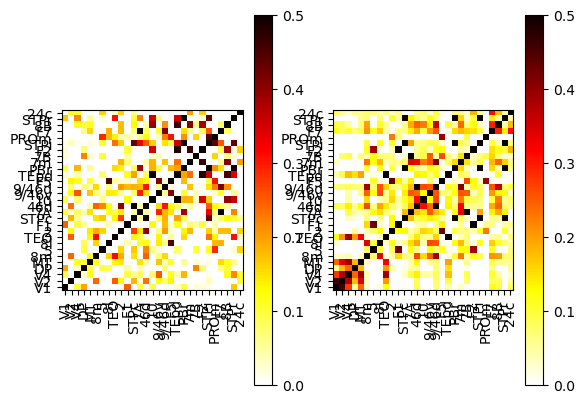

In [103]:
plt.subplot(1, 2, 1)
CC = np.corrcoef(data[0].real)
plt.imshow(CC, cmap="hot_r", vmin=0, vmax=0.5, origin="lower")
plt.yticks(range(Nareas), data.roi.values)
plt.xticks(range(Nareas), data.roi.values, rotation=90)
plt.colorbar()

plt.subplot(1, 2, 2)
CC = np.corrcoef(data[-1].real)
plt.imshow(CC, cmap="hot_r", vmin=0, vmax=0.5, origin="lower")
plt.yticks(range(Nareas), data.roi.values)
plt.xticks(range(Nareas), data.roi.values, rotation=90)
plt.colorbar()

In [105]:
### Decompose in time-frequency domain

# data = data.sel(times=slice(-0.2, 3))


freqs = np.linspace(0.3, 80, 30)

S = tfr_array_morlet(
    data.values.real,
    fsamp / 10,
    freqs,
    freqs / 7,
    output="complex",
    n_jobs=1,
    zero_mean=False,
    verbose=True,
)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values, "roi": area_names},
)

100%|████████████████████████████████████████████████████████| 28/28 [01:16<00:00,  2.72s/it]


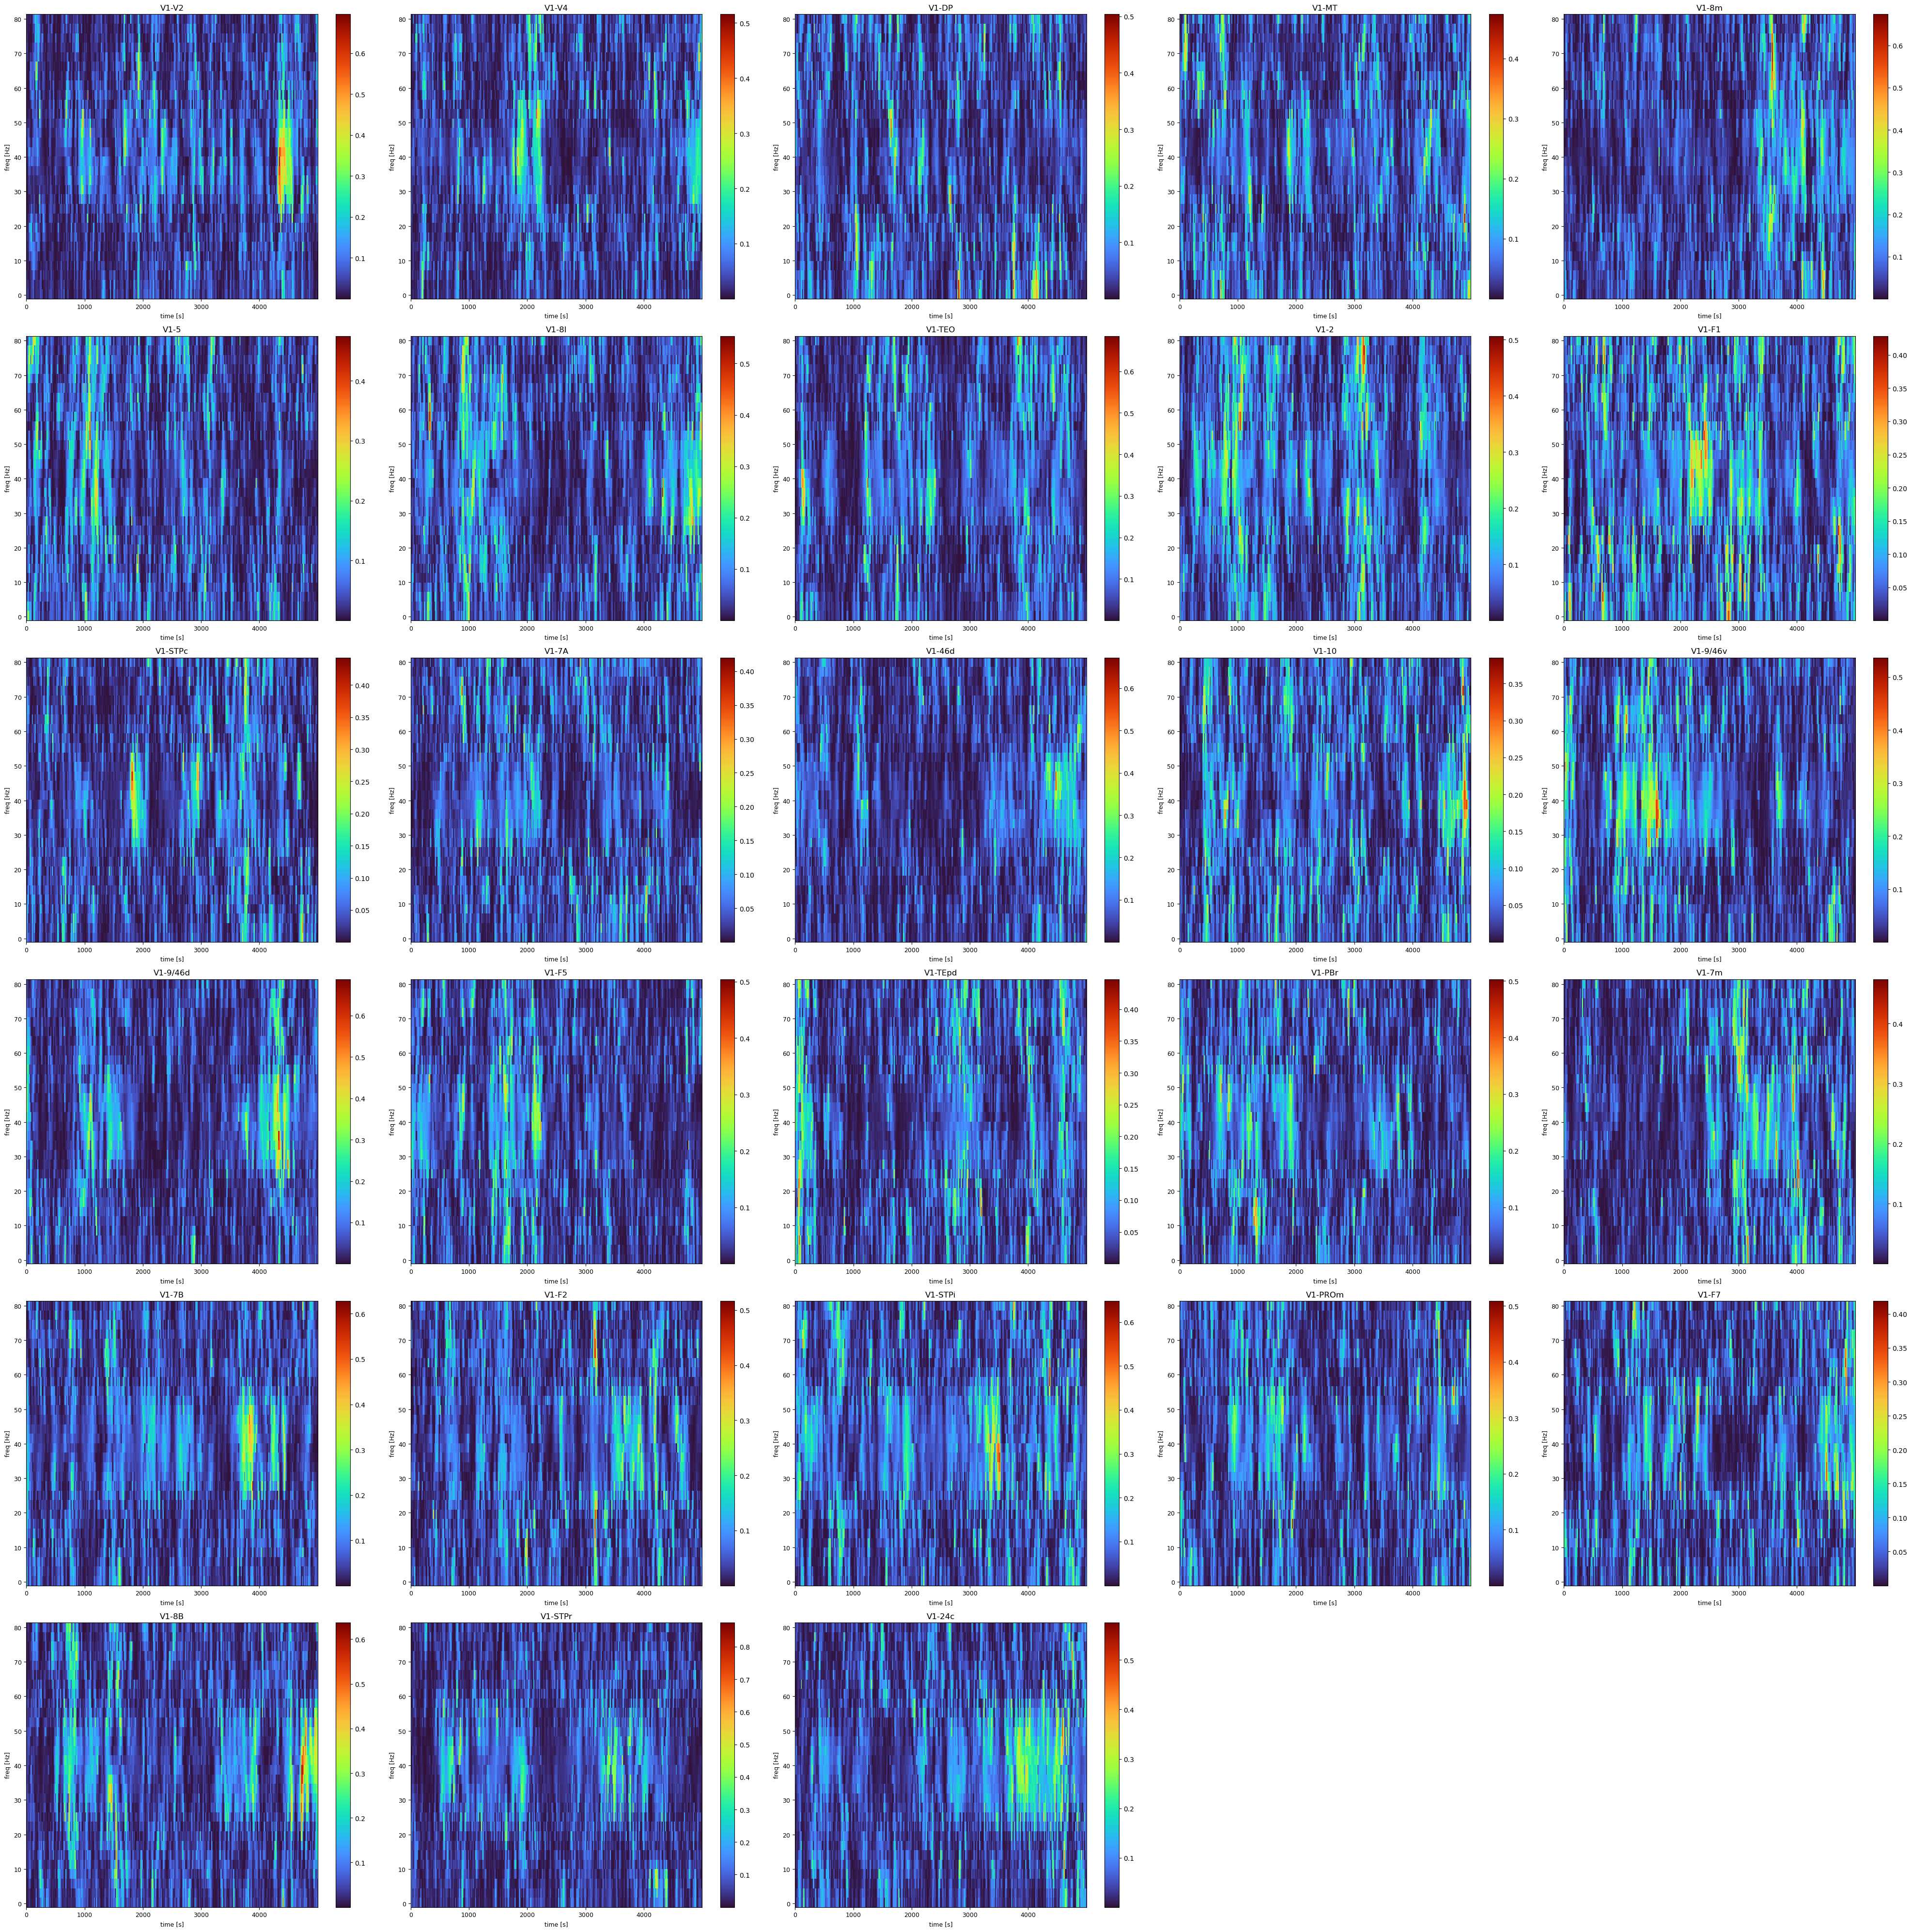

In [107]:
### Compute phase and amplitude terms


def _mi(S, roi_x, roi_y, stim):

    # Define the function to compute MI using HOI and JAX
    mi_fcn = get_mi("gc")

    # vectorize the function to first and second dimension
    gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

    times, freqs = S.times.values, S.freqs.values
    x = S.sel(roi=[roi_x]).data.squeeze()
    y = S.sel(roi=[roi_y]).data.squeeze()

    edge = x * np.conj(y)
    edge_r, edge_i = np.real(edge), np.imag(edge)

    E1 = np.stack((edge_r, edge_i), axis=1)
    E1 = np.moveaxis(E1, [0, 1], [-1, -2])

    # Stims across trials
    stim = data.trials.values
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (len(freqs), data.sizes["times"], 1, 1))

    E1 = copnorm_nd(E1, axis=-1)
    stim = copnorm_nd(stim, axis=-1)

    mi = gcmi(E1, stim).T

    return xr.DataArray(mi, dims=("times", "freqs"), coords=(times, freqs))


pairs = np.stack([[[0] * 28], [range(1, 29)]], axis=1).squeeze().T

rois = S.roi.values
stim = data.trials.values

out = []
for i, j in tqdm(pairs):
    out += [_mi(S, rois[i], rois[j], stim)]


plt.figure(figsize=(40, 40))

for pos, _out in enumerate(out):
    plt.subplot(6, 5, pos + 1)
    i, j = pairs[pos]
    _out.T.plot(
        cmap="turbo",
    )
    plt.title(f"{rois[i]}-{rois[j]}")
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel("freq [Hz]", fontsize=9)
    plt.xlabel("time [s]", fontsize=9)
plt.tight_layout()